<a href="https://colab.research.google.com/github/subhash505/NLP_code/blob/main/Google's%2BT5%2Babstract%2Bsummarization%2Btutorial(hugginface)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google's T5 Abstract Summarization Tutorial
## Overview
T5(Text-to-Text Transfer Transformer) is a model for transfer learning that takes text as input and outputs text, since it is text-to-text.

Examples of text-to-text are
1. translation
2. question and answering
3. classification
4. summarization


Mainly, there are two types of summarization: extractive summarization, in which the original document is excerpted, and generative summarization, in which the original text is conceptually abstracted and rewritten in a different way.
In general, abstract summarization is more difficult.

In this lesson, we will use T5 for abstract summarization.


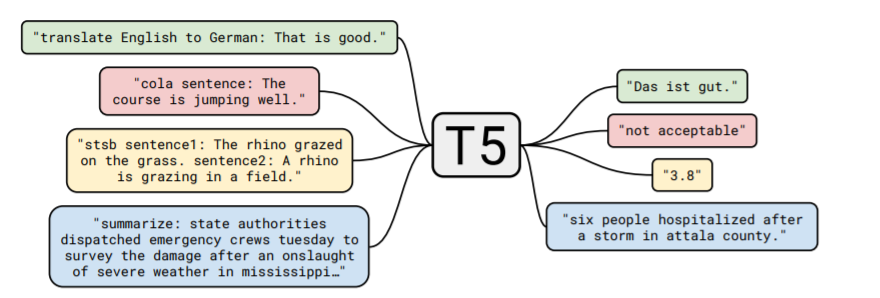


# Change runtime to activate your GPU

# Import libraries

In [ ]:
!pip install transformers
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.3 MB/s 
     |████████████████████████████████| 101 kB 5.6 MB/s 
     |████████████████████████████████| 6.6 MB 42.7 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.1 MB/s 
     |████████████████████████████████| 156 kB 64.8 MB/s 
     |████████████████████████████████| 181 kB 63.7 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b081c9157f87b64ae6fa478d5803c77f26db48d79bbee1ca6ad4ebdb63f9a050
  Stored in directory: /root/.cache/pip

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration

In [ ]:
import wandb

In [ ]:
!nvidia-smi

Wed Aug  3 10:36:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 6.9 MB/s 


# Prepare Data

In [ ]:
df = pd.read_csv('news_summary.csv', encoding='latin-1')

FileNotFoundError: ignored

In [ ]:
df.ctext.iat[0]

'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dama

In [ ]:
df.text.iat[0]

'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [ ]:
df.columns

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')

In [ ]:
df = df[['text', 'ctext']]

In [ ]:
len(df.index)

4514

In [ ]:
df = df.sample(100)

In [ ]:
df.head()

,text,ctext
4235,"All restaurants, including five-star hotels, i...",Come April and you won?t have to go looking fo...
798,The Chinese government has banned singer Justi...,"?I just need one more shot, second chances,? J..."
2321,Pakistan on Saturday accused India of targetin...,Pakistan?s top military officer on Saturday ac...
3352,A 40-year-old woman in Hyderabad was burnt ali...,"In a tragic incident, a woman was burnt alive ..."
2304,The Delhi Police has arrested a man working as...,A man who allegedly threatened to blow up Red ...


In [ ]:
train_size = 0.8

train_dataset = df.sample(frac=train_size, random_state=0)
val_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [ ]:
len(train_dataset.index)

80

In [ ]:
len(val_dataset.index)

20

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, dataframe, tokenizer, source_len, summ_len):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.source_len = source_len
    self.summ_len = summ_len
    self.text = self.data.text
    self.ctext = self.data.ctext
  
  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    ctext = str(self.ctext[index])
    ctext = ' '.join(ctext.split())

    text = str(self.text[index])
    text = ' '.join(text.split())

    source = self.tokenizer.batch_encode_plus([ctext], max_length=self.source_len, pad_to_max_length=True, return_tensors='pt')
    target = self.tokenizer.batch_encode_plus([text], max_length=self.summ_len, pad_to_max_length=True, return_tensors='pt')

    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'source_ids' : source_ids,
        'source_mask' : source_mask,
        'target_ids' : target_ids,
        'target_mask' : target_mask
    }


In [ ]:
tokenizer = T5TokenizerFast.from_pretrained('t5-small')

In [ ]:
tokenizer.batch_encode_plus(['I can do it better'], max_length=32, pad_to_max_length=True, return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': tensor([[ 27,  54, 103,  34, 394,   1,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
training_set = CustomDataset(train_dataset, tokenizer, 512, 150)
val_set = CustomDataset(val_dataset, tokenizer, 512, 150)

In [ ]:
train_params = {
    'batch_size' : 2,
    'shuffle' : True,
    'num_workers' : 0
}

In [ ]:
val_params = {
    'batch_size' : 2,
    'shuffle' : False,
    'num_workers' : 0
}

In [ ]:
training_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

In [ ]:
for i in training_loader:
  print(i)
  break

{'source_ids': tensor([[ 1029,  6110,     7,  ...,    32,   748,     1],
        [23940,     6,  3049,  ...,     0,     0,     0]]), 'source_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'target_ids': tensor([[  272, 13626,    23,  1761,  1625, 11636,  3068,   173,  1311,  1947,
            65,   243,     8,   789,    31,     7,  6384,    12,  8493, 10113,
           334,   215,   823,   681,   523,    34,    42,    59,    19,    96,
          8461,  9018,   816,  1280,    96,  1570,   685,     6,    34,    56,
           582,     3,     9,  1374,  3023,  1032,  4388,   976,  1311,  1947,
           974,     5,     3, 15944,     6,  7338,   287,  7471,     3, 23787,
          9509,  1639,   243,     8,   789,    19,   479,    12,   143, 10113,
          8493,    46,  2041,   605,    11,    56,  2762,     3, 11359,   196,
            31,     7,  5719,     5,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Load pre-trained model

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model = model.to(device)

# Train model(fine tune the model)

In [ ]:
def train(epoch, tokenizer, model, device, loader, optimizer):
  model.train()
  for i, data in enumerate(loader, 0):
    y = data['target_ids'].to(device, dtype=torch.long)
    y_ids = y[:, :-1].contiguous()
    lm_labels = y[:, 1:].clone().detach()
    lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
    ids = data['source_ids'].to(device, dtype = torch.long)
    mask = data['source_mask'].to(device, dtype=torch.long)

    outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
    loss = outputs[0]

    if i % 10  == 0:
      wandb.log({"Training Loss": loss.item()})

    if i % 500 == 0:
      print(f'Epoch:{epoch+1}, Loss:{loss.item()}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def validate(epoch, tokenizer, model, device, loader):
  model.eval()
  predictions = []
  actuals = []

  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      y = data['target_ids'].to(device, dtype=torch.long)
      ids = data['source_ids'].to(device, dtype=torch.long)
      mask = data['source_mask'].to(device, dtype=torch.long)

      generated_ids = model.generate(
          input_ids = ids,
          attention_mask = mask,
          max_length = 150, 
          num_beams = 2,
          repetition_penalty = 2.5,
          length_penalty = 1.0,
          early_stopping = True
      )
      preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
      target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in y]

      predictions.extend(preds)
      actuals.extend(target)

      if i % 100 == 0:
        print(f'Completed: {i}')
  return predictions, actuals

In [ ]:
def main():
  wandb.init(project="transformers_tutorials_summarization")

  config = wandb.config
  config.TRAIN_BATCH_SIZE = 2
  config.VALID_BATCH_SIZE = 2
  config.TRAIN_EPOCHS = 2
  config.VAL_EPOCHS = 1
  config.LEARNING_RATE = 1e-4
  config.SEED = 42
  config.MAX_LEN = 512
  config.SUMMARY_LEN = 150

  # Reproductivity
  torch.manual_seed(config.SEED)
  np.random.seed(config.SEED)
  torch.backends.cudnn.deterministic = True

  optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  wandb.watch(model, log="all")

  for epoch in range(config.TRAIN_EPOCHS):
    train(epoch, tokenizer, model, device, training_loader, optimizer)

  for epoch in range(config.VAL_EPOCHS):
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated Text':predictions, 'Actual Text':actuals})
    final_df.to_csv('./models/predictions.csv')
    print('Ouput files generated for review')

In [ ]:
main()

Training Loss,4.40446
_step,8
_runtime,1590
_timestamp,1611750539


Training Loss,▆▁▁▃▄▂▃█
_step,▁▂▃▄▅▅▆▇█
_runtime,▁▁▁▁▁▁▁▁█
_timestamp,▁▁▁▁▁▁▁▁█


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch:1, Loss:3.440821647644043
Epoch:2, Loss:2.598912000656128
Completed: 0
Ouput files generated for review


# Make inference using test data loader

In [ ]:
final_df = pd.read_csv('./models/predictions.csv')

In [ ]:
final_df.head()

,Unnamed: 0,Generated Text,Actual Text
0,0,fell 60 feet off the restricted area of Forest...,"A woman, who fell from the tallest bridge in U..."
1,1,i project fellow Hashim Sofi has left BITS Pil...,"Hashim Sofi, a Kashmiri scholar at Birla Insti..."
2,2,from the University of Delaware (UD) in the US...,US-based researchers tested a cluster of trees...
3,3,and Alia Bhatt the India Today Conclave 2017 i...,Filmmaker Karan Johar has said that he would m...
4,4,Nan,Mobile network has not yet reached as many as ...


In [ ]:
final_df.at[0, 'Generated Text']

'fell 60 feet off the restricted area of Foresthill Bridge near Auburn, California, while taking a selfie. she was airlifted to Sutter Roseville Medical Center for treatment. police in a California county put out a Facebook post after she fell, warning thrill seekers that, "You can lose your life and none of that is worth a selfie!"'

In [ ]:
final_df.at[0, 'Actual Text']

"A woman, who fell from the tallest bridge in USA's California while taking a selfie and landed 60 feet below on a trail, is expected to survive, the Placer County Sheriff's office said. The woman suffered several fractured bones and requires surgery. She fell from the 730-feet-tall Foresthill Bridge, the highest in California and among the highest in the US."

In [ ]:
val_dataset.ctext.iat[0]

'A woman fell 60 feet from one of the US tallest bridges while taking a selfie but miraculously survived after landing on a trail below. The Sacramento-area woman was expected to survive after she fell 60 feet off the restricted area of the Foresthill Bridge near Auburn, California, while trying to take a selfie, the Placer County Sheriffs Office said. Paul Goncharuk, a friend of the woman, told CNN affiliate KOVR that "she was knocked unconscious, suffered a deep gash to her arm and fractured bones that will require surgery." Goncharuk also confirmed that "they were taking a picture on the bridge, and then the big bolts that are holding the beams together, she stepped on them kind of weirdly and lost balance and fell backwards." Police in a California county put out a Facebook post after she fell, warning camera-toting thrill seekers that, "You can lose your life and none of that is worth a selfie!" The 730-foot-tall bridge is the highest in California and one of the highest in the Un

# Final project

Assignment: Using the above program as a reference, write a source code that takes the text of the article [Starbuck's description (WIKIPEDIA)](https://en.wikipedia.org/wiki/Starbucks) as input and summarizes it, one summary at a time.

# Answer


In [ ]:
english_text = """
Starbucks Corporation is an American multinational chain of coffeehouses and roastery reserves headquartered in Seattle, Washington. As the world's largest coffeehouse chain, Starbucks is seen to be the main representation of the United States' second wave of coffee culture.[6][7] As of early 2020, the company operates over 30,000 locations worldwide in more than 70 countries. Starbucks locations serve hot and cold drinks, whole-bean coffee, microground instant coffee known as VIA, espresso, caffe latte, full- and loose-leaf teas including Teavana tea products, Evolution Fresh juices, Frappuccino beverages, La Boulange pastries, and snacks including items such as chips and crackers; some offerings (including their annual fall launch of the Pumpkin Spice Latte) are seasonal or specific to the locality of the store.

Headquartered in the Starbucks Center, the company was founded in 1971 by Jerry Baldwin, Zev Siegl, and Gordon Bowker at Seattle's Pike Place Market. During the early 1980s, they sold the company to Howard Schultz who – after a business trip to Milan, Italy – decided to make the coffee bean store a coffeeshop serving espresso-based drinks. Schultz's first tenure as chief executive, from 1986 to 2000, led to an aggressive expansion of the franchise, first in Seattle, then across the U.S. West Coast. Despite an initial economic downturn with its expansion into the Midwest and British Columbia, the company experienced revitalized prosperity with its entry into California in the early 1990s through a series of highly publicized coffee wars. Schultz was succeeded by Orin Smith who ran the company for five years, positioning Starbucks as a large player in fair trade coffee and increasing sales to $5 billion. Jim Donald served as chief executive from 2005 to 2008, orchestrating a large-scale earnings expansion. Schultz returned as CEO in the middle of the 2008 financial crisis and spent the succeeding decade growing its market share, expanding its offerings, and reorienting itself around corporate social responsibility. Kevin Johnson took over from Schultz in 2017, and continues to serve as the firm's chief executive.

Many stores sell pre-packaged food items, pastries, hot and cold sandwiches, and drinkware including mugs and tumblers. There are also several select "Starbucks Evenings" locations which offer beer, wine, and appetizers. Starbucks-brand coffee, ice cream, and bottled cold coffee drinks are also sold at grocery stores in the United States and other countries. In 2010, the company began its Starbucks Reserve program for single-origin coffees and high-end coffee shops. It planned to open 1,000 Reserve coffee shops by the end of 2017.[8] Starbucks operates six roasteries with tasting rooms and 43 coffee bars as part of the program. The latest roastery location opened on Chicago's Magnificent Mile in November 2019, and is the world's largest Starbucks. The company has received significant and sustained criticism about its business practices, corporate affairs, and role in society. Conversely, its franchise has commanded substantial brand loyalty, market share, and company value.
"""

In [ ]:
encoded_text_mask = tokenizer.encode_plus(english_text, max_length=512, pad_to_max_length=True, return_tensors='pt')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_text_mask['input_ids']

tensor([[24474,  6708,    19,    46,   797, 23089,  3741,    13,  1975,  1840,
             7,    11, 14238,  4203, 11222,     3, 27630,    16,  8854,     6,
          2386,     5,   282,     8,   296,    31,     7,  2015,  1975,  1840,
          3741,     6, 24474,    19,   894,    12,    36,     8,   711,  6497,
            13,     8,   907,  1323,    31,   511,  6772,    13,  1975,  1543,
             5,  6306,   948,   908,  6306,   940,   908,   282,    13,   778,
          6503,     6,     8,   349, 10291,   147,     3, 17093,  3248,  4388,
            16,    72,   145,  2861,  1440,     5, 24474,  3248,  1716,  1312,
            11,  2107,  6750,     6,   829,    18,   346,   152,  1975,     6,
          2179,  9232,  5087,  1975,   801,    38,  9766,   188,     6, 22311,
             6,   212,  7398,     3,    40, 10206,     6,   423,    18,    11,
          6044,    18,   109,     9,    89,  2198,     7,   379,  8250,  2132,
             9,  2198,   494,     6, 21625,  8767,  

In [ ]:
encoded_text_mask['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [ ]:
generated_ids = model.generate(
          input_ids = encoded_text_mask['input_ids'].to(device),
          attention_mask = encoded_text_mask['attention_mask'].to(device),
          max_length = 30, 
          num_beams = 2,
          repetition_penalty = 2.5,
          length_penalty = 1.0,
          early_stopping = True
)

In [ ]:
[tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]

['Corporation is an American multinational chain of coffeehouses and roastery reserves headquartered in Seattle, Washington. Starbucks operates over 30,000 locations worldwide']